In [ ]:
!pip install networkx simpy pyod --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.7/204.7 kB 8.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import random
from datetime import datetime, timedelta

In [ ]:
# Create local folders
import os
os.makedirs('/content/rural_mesh/data', exist_ok=True)
os.makedirs('/content/rural_mesh/notebooks', exist_ok=True)

In [ ]:
# There are no specific dataset available for free so we are proceeding for making our own dataset

schema = [
    'timestamp',         # ISO string
    'node_id',           # int
    'battery_level',     # 0–100
    'traffic_load',      # Mbps (float)
    'link_status',       # up or degraded or down
    'weather',           # clear or cloudy or rain or storm
    'anomaly_type',      # none or battery_outage or congestion or weather_outage
    'anomaly_flag'       # either 0 or 1
]
schema

['timestamp',
 'node_id',
 'battery_level',
 'traffic_load',
 'link_status',
 'weather',
 'anomaly_type',
 'anomaly_flag']

In [ ]:
# Building a mesh like neural network topology

NUM_NODES = 25 # no of nodes in our topology
RADIUS = 0.35  # connectivity; larger = more edges

np.random.seed(42)
G = nx.random_geometric_graph(NUM_NODES, radius=RADIUS)

# Ensure single connected component
if not nx.is_connected(G):
    comps = list(nx.connected_components(G))
    for i in range(len(comps)-1):
        u = list(comps[i])[0]
        v = list(comps[i+1])[0]
        G.add_edge(u, v)

print(f'Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}')

Nodes: 25, Edges: 72


In [ ]:
# Simulate one-day of time series data with anomalies

def pick_weather():
    return random.choices(
        population=['clear','cloudy','rain','storm'],
        weights=[0.55,0.25,0.15,0.05], k=1
    )[0]

def solar_charge_factor(dt):
    # Assuming stronger charge 9–16, shoulder 7–9 & 16–18
    h = dt.hour
    if 9 <= h <= 16: return 1.0
    if 7 <= h < 9 or 16 < h <= 18: return 0.5
    return 0.0

start = datetime(2025, 1, 1, 6, 0, 0)
MINUTES = 24 * 60  # one full day
records = []

for node in range(G.number_of_nodes()):
    battery = float(np.clip(np.random.normal(70, 8), 35, 95))
    base_traffic = float(np.clip(np.random.normal(2.2, 0.4), 0.6, 4.2))  # Mbps

    for m in range(MINUTES):
        ts = start + timedelta(minutes=m)
        w = pick_weather()

        # Hourly traffic rhythm + noise
        traffic = base_traffic + np.sin((ts.hour/24)*2*np.pi)*1.0 + np.random.normal(0,0.2)
        traffic = max(0.0, traffic)

        # Battery dynamics (charge by sun, discharge by load)
        charge = 1.8 * solar_charge_factor(ts)
        discharge = (0.025 * traffic) + np.random.normal(0.018, 0.008)
        battery = float(np.clip(battery + charge - (discharge*100), 0, 100))

        # Link status baseline
        link_status = 'up'
        if w == 'storm' and random.random() < 0.15:
            link_status = 'down'
        elif w == 'rain' and random.random() < 0.08:
            link_status = 'degraded'

        # Anomaly injection
        anomaly_type = 'none'
        anomaly_flag = 0

        # Battery outage (low battery causes link down)
        if battery < 8 and random.random() < 0.7:
            anomaly_type = 'battery_outage'
            anomaly_flag = 1
            link_status = 'down'

        # Congestion anomaly (traffic spike degrades link)
        if traffic > 4.5 and random.random() < 0.4:
            anomaly_type = 'congestion'
            anomaly_flag = 1
            if link_status == 'up':
                link_status = 'degraded'

        # Weather outage anomaly (storm + down)
        if w == 'storm' and link_status == 'down':
            anomaly_type = 'weather_outage'
            anomaly_flag = 1

        records.append({
            'timestamp': ts.isoformat(),
            'node_id': node,
            'battery_level': round(battery,2),
            'traffic_load': round(traffic,3),
            'link_status': link_status,
            'weather': w,
            'anomaly_type': anomaly_type,
            'anomaly_flag': anomaly_flag
        })

df = pd.DataFrame(records)
df.head()

,timestamp,node_id,battery_level,traffic_load,link_status,weather,anomaly_type,anomaly_flag
0,2025-01-01T06:00:00,0,73.03,3.057,up,cloudy,none,0
1,2025-01-01T06:01:00,0,62.31,3.863,up,clear,none,0
2,2025-01-01T06:02:00,0,50.63,3.490,up,clear,none,0
3,2025-01-01T06:03:00,0,40.35,3.581,up,clear,none,0
4,2025-01-01T06:04:00,0,27.89,3.420,up,cloudy,none,0


In [ ]:
csv_path = '/content/rural_mesh/data/mesh_logs.csv'
df.to_csv(csv_path, index=False)
csv_path

'/content/rural_mesh/data/mesh_logs.csv'

In [ ]:
import pandas as pd

# Extract edges from your NetworkX graph G
edges = [{'source_id': u, 'target_id': v} for u, v in G.edges()]

# Convert to DataFrame
edges_df = pd.DataFrame(edges)

# Save to CSV
edges_df.to_csv('mesh_edges.csv', index=False)

In [ ]:
from google.colab import files
files.download('mesh_edges.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
files.download('mesh_logs.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Validate data quality

print(df.shape)
print(df.isna().sum())

# Sanity checks
print('Battery min/max:', df['battery_level'].min(), df['battery_level'].max())
print('Traffic min/max:', df['traffic_load'].min(), df['traffic_load'].max())
print('Link status:', df['link_status'].value_counts().to_dict())
print('Weather:', df['weather'].value_counts().to_dict())
print('Anomaly types:', df['anomaly_type'].value_counts().to_dict())
print('Anomaly ratio:', df['anomaly_flag'].mean())

(36000, 8)
timestamp        0
node_id          0
battery_level    0
traffic_load     0
link_status      0
weather          0
anomaly_type     0
anomaly_flag     0
dtype: int64
Battery min/max: 0.0 74.85
Traffic min/max: 0.106 4.466
Link status: {'down': 25442, 'up': 10444, 'degraded': 114}
Weather: {'clear': 19733, 'cloudy': 9006, 'rain': 5369, 'storm': 1892}
Anomaly types: {'battery_outage': 23983, 'none': 10558, 'weather_outage': 1459}
Anomaly ratio: 0.7067222222222223


In [ ]:
# Preprocess for modelling

# Encode categoricals
cat_cols = ['link_status','weather','anomaly_type']
df_enc = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Sort by time to avoid leakage
df_enc['timestamp'] = pd.to_datetime(df_enc['timestamp'])
df_enc = df_enc.sort_values('timestamp').reset_index(drop=True)

# Feature matrix and target
features = [c for c in df_enc.columns if c not in ['timestamp','anomaly_flag']]
X = df_enc[features]
y = df_enc['anomaly_flag']

# Time-based split
split_idx = int(0.8 * len(df_enc))
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

In [ ]:
# Baseline rule check

def rule_based_flags(df_raw):
    return (
        (df_raw['battery_level'] < 10) |
        (df_raw['traffic_load'] > 4.5) |
        ((df_raw['weather'] == 'storm') & (df_raw['link_status'] == 'down'))
    ).astype(int)

rb = rule_based_flags(df)
print('Rule-based anomaly ratio:', rb.mean())

Rule-based anomaly ratio: 0.996


In [ ]:
# Train a model with anomaly using isolationforest

from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_recall_fscore_support

iso = IsolationForest(n_estimators=200, contamination='auto', random_state=42)
iso.fit(X_train)

pred_labels = (iso.predict(X_test) == -1).astype(int)

prec, rec, f1, _ = precision_recall_fscore_support(y_test, pred_labels, average='binary', zero_division=0)
print(f'IsolationForest -> Precision: {prec:.3f}, Recall: {rec:.3f}, F1: {f1:.3f}')

IsolationForest -> Precision: 0.592, Recall: 0.391, F1: 0.471


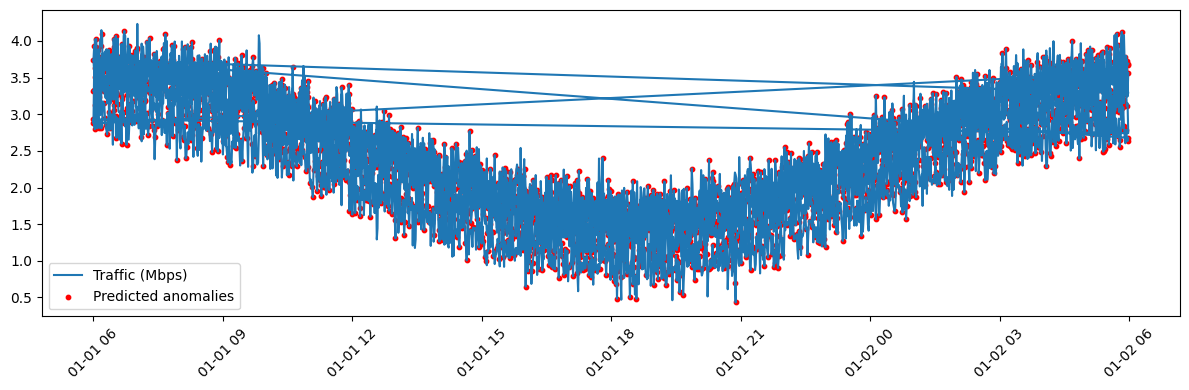

In [ ]:
# Visualize anomalies over time

import matplotlib.pyplot as plt

test_df = df.iloc[split_idx:].copy()
test_df['pred_anomaly'] = pred_labels

plt.figure(figsize=(12,4))
plt.plot(pd.to_datetime(test_df['timestamp']), test_df['traffic_load'], label='Traffic (Mbps)')
plt.scatter(pd.to_datetime(test_df['timestamp'])[test_df['pred_anomaly']==1],
            test_df['traffic_load'][test_df['pred_anomaly']==1],
            color='red', s=10, label='Predicted anomalies')
plt.legend(); plt.xticks(rotation=45); plt.tight_layout(); plt.show()

In [ ]:
import joblib
joblib.dump(iso, '/content/rural_mesh/iso_model.joblib')

['/content/rural_mesh/iso_model.joblib']

In [ ]:
# Sort by node and time
df_sorted = df.sort_values(['node_id','timestamp']).copy()
df_sorted['timestamp'] = pd.to_datetime(df_sorted['timestamp'])

# Rolling features
for win in [15, 30, 60]:  # minutes
    df_sorted[f'battery_roll_mean_{win}'] = df_sorted.groupby('node_id')['battery_level'].transform(
        lambda s: s.rolling(win, min_periods=1).mean())
    df_sorted[f'traffic_roll_std_{win}'] = df_sorted.groupby('node_id')['traffic_load'].transform(
        lambda s: s.rolling(win, min_periods=1).std().fillna(0))

df_sorted.head()

,timestamp,node_id,battery_level,traffic_load,link_status,weather,anomaly_type,anomaly_flag,battery_roll_mean_15,traffic_roll_std_15,battery_roll_mean_30,traffic_roll_std_30,battery_roll_mean_60,traffic_roll_std_60
0,2025-01-01 06:00:00,0,62.77,3.274,up,cloudy,none,0,62.770000,0.000000,62.770000,0.000000,62.770000,0.000000
1,2025-01-01 06:01:00,0,53.41,3.098,up,clear,none,0,58.090000,0.124451,58.090000,0.124451,58.090000,0.124451
2,2025-01-01 06:02:00,0,42.35,3.461,up,cloudy,none,0,52.843333,0.181528,52.843333,0.181528,52.843333,0.181528
3,2025-01-01 06:03:00,0,32.49,3.051,up,clear,none,0,47.755000,0.186582,47.755000,0.186582,47.755000,0.186582
4,2025-01-01 06:04:00,0,23.43,3.052,up,clear,none,0,42.890000,0.178386,42.890000,0.178386,42.890000,0.178386


In [ ]:
# Encode categoricals again
cat_cols = ['link_status','weather','anomaly_type']
df_enc2 = pd.get_dummies(df_sorted, columns=cat_cols, drop_first=True)

# Feature matrix and target
features2 = [c for c in df_enc2.columns if c not in ['timestamp','anomaly_flag']]
X2 = df_enc2[features2]
y2 = df_enc2['anomaly_flag']

# Time-based split
split_idx2 = int(0.8 * len(df_enc2))
X_train2, X_test2 = X2.iloc[:split_idx2], X2.iloc[split_idx2:]
y_train2, y_test2 = y2.iloc[:split_idx2], y2.iloc[split_idx2:]

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train2, y_train2)
rf_preds = rf.predict(X_test2)

print(classification_report(y_test2, rf_preds, zero_division=0))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2084
           1       1.00      1.00      1.00      5116

    accuracy                           1.00      7200
   macro avg       1.00      1.00      1.00      7200
weighted avg       1.00      1.00      1.00      7200



In [ ]:
# Comapre models

iso2 = IsolationForest(n_estimators=200, contamination='auto', random_state=42)
iso2.fit(X_train2)
iso_preds = (iso2.predict(X_test2) == -1).astype(int)

print("Isolation Forest F1:",
      classification_report(y_test2, iso_preds, zero_division=0))

Isolation Forest F1:               precision    recall  f1-score   support

           0       0.21      0.57      0.31      2084
           1       0.40      0.12      0.18      5116

    accuracy                           0.25      7200
   macro avg       0.30      0.34      0.24      7200
weighted avg       0.34      0.25      0.22      7200



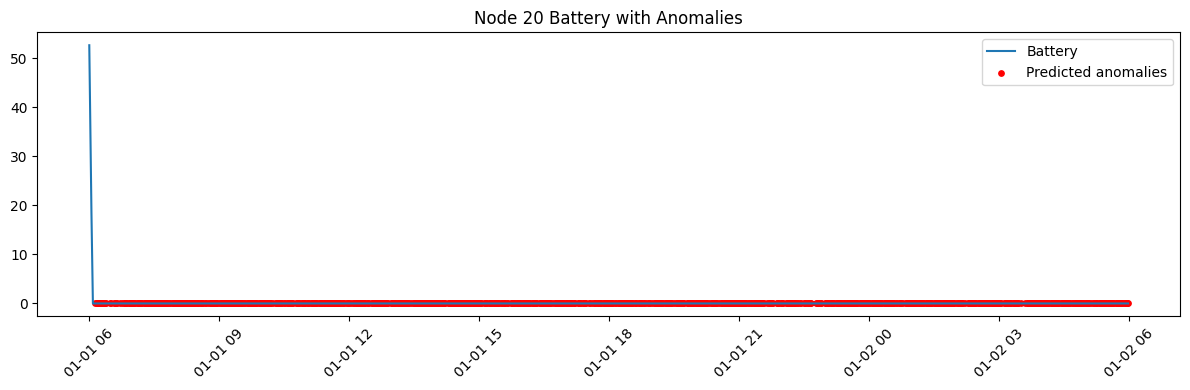

In [ ]:
# Visualize node-wise anomalies

import matplotlib.pyplot as plt

test_df2 = df_sorted.iloc[split_idx2:].copy()
test_df2['rf_pred'] = rf_preds

node_sample = random.choice(test_df2['node_id'].unique())
node_data = test_df2[test_df2['node_id']==node_sample]

plt.figure(figsize=(12,4))
plt.plot(node_data['timestamp'], node_data['battery_level'], label='Battery')
plt.scatter(node_data['timestamp'][node_data['rf_pred']==1],
            node_data['battery_level'][node_data['rf_pred']==1],
            color='red', s=15, label='Predicted anomalies')
plt.title(f'Node {node_sample} Battery with Anomalies')
plt.xticks(rotation=45); plt.legend(); plt.tight_layout(); plt.show()

In [ ]:
!pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 12.7 MB/s eta 0:00:00


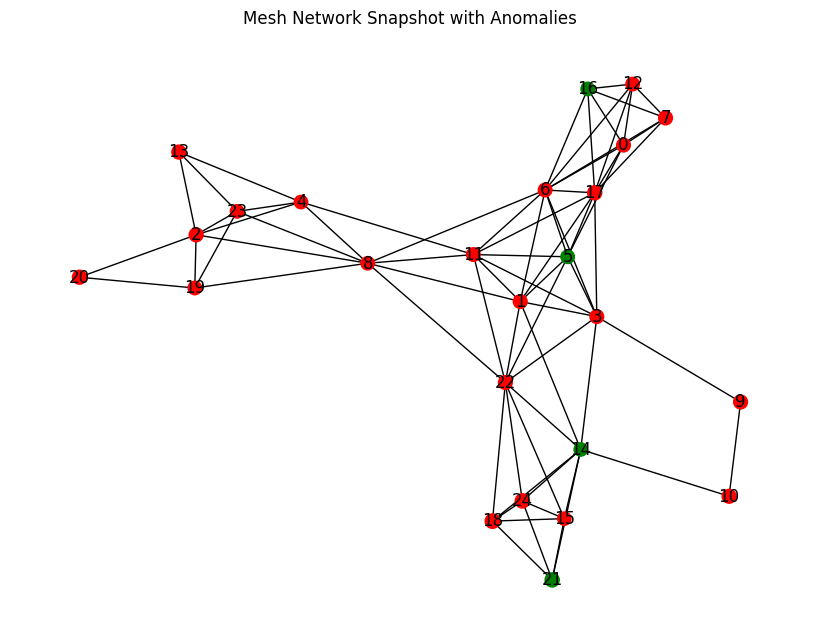

In [ ]:
import matplotlib.pyplot as plt

# Snapshot at a given time
snapshot = df[df['timestamp'] == df['timestamp'].unique()[500]]  # pick a time index

colors = ['red' if flag==1 else 'green' for flag in snapshot['anomaly_flag']]
sizes = [80 + t*10 for t in snapshot['traffic_load']]  # bigger node = higher traffic

plt.figure(figsize=(8,6))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, node_color=colors, node_size=sizes, with_labels=True)
plt.title("Mesh Network Snapshot with Anomalies")
plt.show()

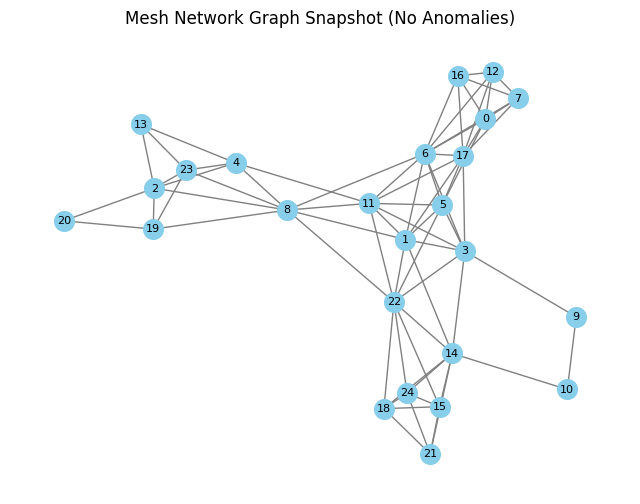

In [ ]:
import matplotlib.pyplot as plt

# Use the same network G you created earlier with NetworkX
plt.figure(figsize=(8,6))

# Layout for positioning nodes
pos = nx.spring_layout(G, seed=42)

# Draw nodes (all in blue, no anomaly coloring)
nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=200)

# Draw edges
nx.draw_networkx_edges(G, pos, edge_color='gray')

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=8)

plt.title("Mesh Network Graph Snapshot (No Anomalies)")
plt.axis('off')
plt.show()

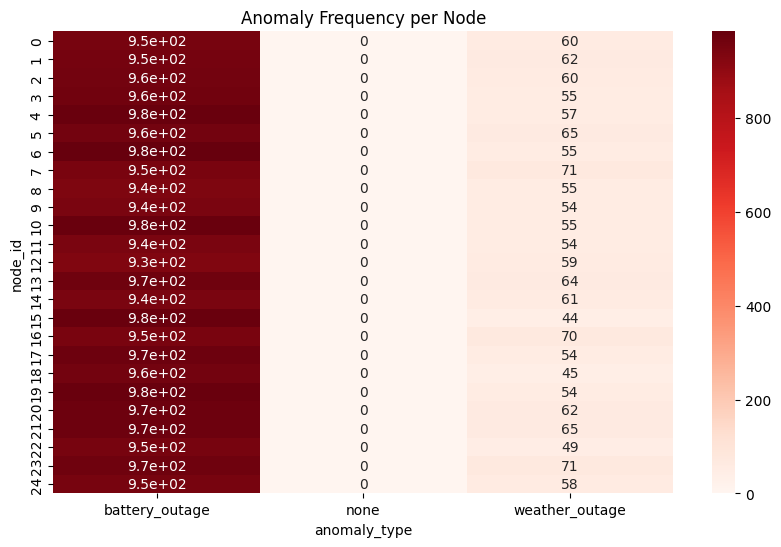

In [ ]:
import seaborn as sns

pivot = df.pivot_table(index='node_id', columns='anomaly_type', values='anomaly_flag', aggfunc='sum').fillna(0)
plt.figure(figsize=(10,6))
sns.heatmap(pivot, annot=True, cmap="Reds")
plt.title("Anomaly Frequency per Node")
plt.show()

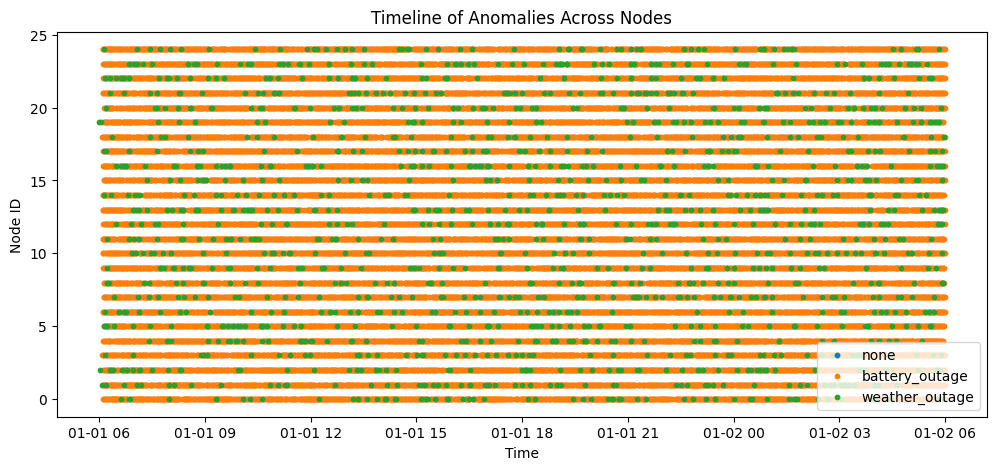

In [ ]:
plt.figure(figsize=(12,5))
for anomaly in df['anomaly_type'].unique():
    subset = df[(df['anomaly_type']==anomaly) & (df['anomaly_flag']==1)]
    plt.scatter(pd.to_datetime(subset['timestamp']), subset['node_id'], label=anomaly, s=10)

plt.legend()
plt.title("Timeline of Anomalies Across Nodes")
plt.xlabel("Time")
plt.ylabel("Node ID")
plt.show()

/tmp/ipython-input-3213143941.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='anomaly_flag', y='battery_level', data=df, palette="Set2")


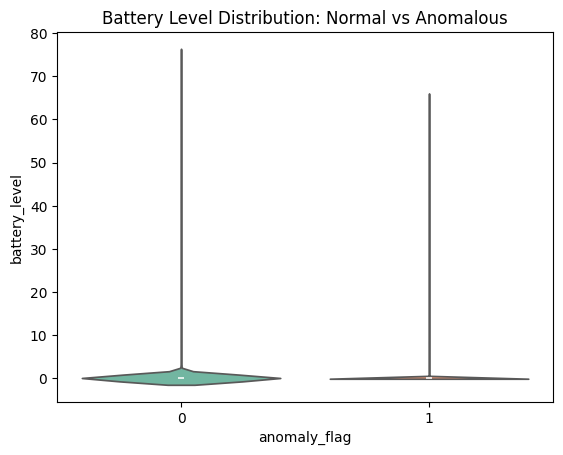

In [ ]:
sns.violinplot(x='anomaly_flag', y='battery_level', data=df, palette="Set2")
plt.title("Battery Level Distribution: Normal vs Anomalous")
plt.show()

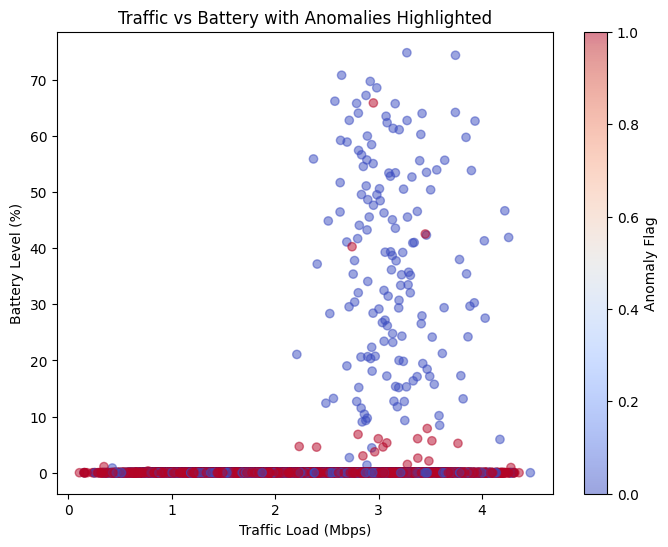

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(df['traffic_load'], df['battery_level'],
            c=df['anomaly_flag'], cmap='coolwarm', alpha=0.5)
plt.xlabel("Traffic Load (Mbps)")
plt.ylabel("Battery Level (%)")
plt.title("Traffic vs Battery with Anomalies Highlighted")
plt.colorbar(label="Anomaly Flag")
plt.show()